In [1]:
REPORT_PREFIX = "../out/reports/wfp_full__model_svmrbf__dummies_1__tracelen_2000__iter_2000"
DATA_PATH = "../data/wfp/batch__tracelen_2000/"
# DEF_SUMMARY_PATH = "../out/wfp_defenses/wfp_defense_compare.csv"
DEFENSES_PREFIX = "../out/wfp_defenses"

TRACE_LEN = 2000

FIGS_PATH = '../out/images'
FIGWIDTH = 8.5
FIGHEIGHT = 6.5
SAVE_PLOTS = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import tqdm

from joypy import joyplot

from scipy.stats import entropy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split

from trickster.domain.wfp import load_data, load_cell_data, extract
from scripts.wfp_attacks import prepare_data

/home/bogdan/Workspace/trickster/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
import plot_params

In [6]:
def save_fig(fig, name_template, *args, **kwargs):
    fig.savefig(os.path.join(FIGS_PATH, name_template.format(*args, **kwargs)))

## Load and process the data produced by the experiment runs

In [7]:
with open(REPORT_PREFIX + '.pkl', 'rb') as f:
    adv_results = pickle.load(f)
    
random_results_set = []
for i in range(1, 10+1):
    with open(REPORT_PREFIX + '__random_%i.pkl' % i, 'rb') as f:
        random_results_set.append(('Random search', pickle.load(f)))

In [8]:
with open("../out/models/model_full_svmrbf_cumul.pkl", "rb") as f:
    svm = pickle.load(f)
    
def get_confidence(x):
    return svm.predict_proba([x])[0, 1]

In [9]:
summary_columns = [
    'filename', 'tracelen', 'defense', 'packets_added', 'svmpred', 'orig_svmpred',
]

In [10]:
idxs, orig_traces, labels = load_data(DATA_PATH, return_idxs=True, verbose=False)
traces_by_trace_id = {
    trace_id: trace
    for trace_id, trace in zip(idxs, orig_traces)
}
featurevecs_by_trace_id = {
    trace_id: extract(trace)
    for trace_id, trace in tqdm.tqdm_notebook(list(zip(idxs, orig_traces)))
}

In [11]:
GS_DEF_NAME = "Hill climbing"

In [12]:
gs_summary = pd.DataFrame(columns=summary_columns)
gs_trace_ids = None

dfs = [(GS_DEF_NAME, adv_results)] + random_results_set
for defense_name, df in dfs:
    print(defense_name)
    if gs_trace_ids is None:
        gs_trace_ids = set(df.filename)
    else:
        if set(df.filename) != gs_trace_ids:
            print(defense_name, "Something's broken here.")
            continue

    for _, row in tqdm.tqdm_notebook(list(df.iterrows())):
        orig_x = featurevecs_by_trace_id[row.filename]
        orig_svm_pred = get_confidence(orig_x)
        if row.found:
            adv_x_features = extract(row.adv_x)
            gs_summary = gs_summary.append({
                'filename': row.filename,
                'tracelen': len(row.adv_x),
                'packets_added': len(row.adv_x) - len(row.x),
                'dirratio': len(np.array(row.x) < 0) / (len(np.array(row.x) > 0) + 1),
                'svmpred': get_confidence(adv_x_features),
                'orig_svmpred': orig_svm_pred,
                'defense': defense_name
            }, ignore_index=True)
        else:
            gs_summary = gs_summary.append({
                'filename': row.filename,
                'tracelen': len(row.x),
                'svmpred': 0,
                'orig_svmpred': orig_svm_pred,
                'defense': defense_name
            }, ignore_index=True)

Hill climbing



Random search
Random search Something's broken here.
Random search
Random search Something's broken here.
Random search
Random search Something's broken here.
Random search
Random search Something's broken here.
Random search
Random search Something's broken here.
Random search



Random search
Random search Something's broken here.
Random search
Random search Something's broken here.
Random search



Random search


In [13]:
defense_name_map = {
    "BuFLO": "buflo",
    "CS BuFLO": "cs_buflo",
    "Decoy": "decoy",
    "WTF-PAD": "wtfpad",
}

In [14]:
np.mean(["-" in trace_id for trace_id in gs_trace_ids])

0.9930675909878682

In [15]:
gs_summary.query("filename == '92-6'")

,filename,tracelen,defense,packets_added,svmpred,orig_svmpred,dirratio
6,92-6,1969,Hill climbing,43,0.526000,0.010948,0.999481
583,92-6,2000,Random search,74,0.523197,0.010948,0.999481
1160,92-6,2000,Random search,74,0.519107,0.010948,0.999481
1737,92-6,2000,Random search,74,0.510124,0.010948,0.999481


In [16]:
def get_defense_summary(defense, trace_ids, traces):
    summary = pd.DataFrame(columns=summary_columns)
    for trace_id, trace in tqdm.tqdm_notebook(list(zip(trace_ids, traces))):
        x = extract(trace)
        orig_trace = traces_by_trace_id[trace_id]
        orig_x = featurevecs_by_trace_id[trace_id]
        summary = summary.append([{
            'filename': trace_id,
            'defense': defense,
            'packets_added': len(trace) - len(orig_trace),
            'dirratio': len(np.array(trace) < 0) / (len(np.array(trace) > 0) + 1),
            'svmpred':  get_confidence(x),
            'orig_svmpred': get_confidence(orig_x),
            'tracelen': len(orig_trace),
        }], ignore_index=True)
    return summary

In [17]:
baseline_defenses = defense_name_map.keys()
def_summary = pd.DataFrame()
for defense in baseline_defenses:
    traces_path = os.path.join(
        DEFENSES_PREFIX, "trace_len_%i/%s" % (TRACE_LEN, defense_name_map[defense]))
    print("Loading", traces_path)
    trace_ids, traces, labels = load_data(
        traces_path, verbose=False, return_idxs=True)
    
    print("Using %i/%i traces" % (
        len(gs_trace_ids.intersection(trace_ids)), len(gs_trace_ids)))
    
    print("Missing traces: ", gs_trace_ids - set(trace_ids))
    
#     non_monitored_idxs = labels == 0
    mask = np.isin(trace_ids, list(gs_trace_ids))
    traces = traces[mask]
    trace_ids = trace_ids[mask]
    labels = labels[mask]
    
    def_summary = def_summary.append(get_defense_summary(
        defense, trace_ids, traces))

Loading ../out/wfp_defenses/trace_len_2000/buflo
Using 573/577 traces
Missing traces:  {'5608', '1815', '1570', '4144'}



Loading ../out/wfp_defenses/trace_len_2000/cs_buflo
Using 573/577 traces
Missing traces:  {'5608', '1815', '1570', '4144'}



Loading ../out/wfp_defenses/trace_len_2000/decoy
Using 573/577 traces
Missing traces:  {'5608', '1815', '1570', '4144'}



Loading ../out/wfp_defenses/trace_len_2000/wtfpad
Using 577/577 traces
Missing traces:  set()


In [18]:
all_defenses_summary = gs_summary.append(def_summary.query("defense != 'Original'"))
all_defenses_summary['packets_added'] = all_defenses_summary['packets_added'].astype(float)

all_defenses_summary.groupby("defense").mean()

,dirratio,orig_svmpred,packets_added,svmpred
defense,,,,
BuFLO,0.999762,0.009801,3542.195462,0.802968
CS BuFLO,0.996764,0.009801,408.958115,0.632556
Decoy,0.998533,0.009801,740.040140,0.773204
Hill climbing,0.990406,0.011079,12.223570,0.563467
Random search,0.990401,0.011079,111.637572,0.547114
WTF-PAD,0.996638,0.011079,409.634315,0.615621


In [19]:
success_data = pd.DataFrame(columns=["defense", "filename", "success"])
success_data.defense = all_defenses_summary.defense
success_data.filename = all_defenses_summary.filename
success_data.success = (all_defenses_summary["svmpred"] >= 0.50)

success_data.groupby("defense").mean()

,success
defense,
BuFLO,1.000000
CS BuFLO,0.746946
Decoy,0.808028
Hill climbing,1.000000
Random search,0.999422
WTF-PAD,0.688042


In [20]:
defense_names = [GS_DEF_NAME, 'Random search'] + list(baseline_defenses)

In [21]:
overhead_data = pd.DataFrame()
baseline_df = all_defenses_summary.query("defense == '%s'" % GS_DEF_NAME)
for _, row in tqdm.tqdm_notebook(list(baseline_df.iterrows())):
    t = all_defenses_summary.query(
        "filename=='%s' and defense not in ['Original', '%s']" % (row.filename, GS_DEF_NAME))
    def_overheads = t.pivot_table(
        columns="defense",
        values="packets_added",
        index="filename"
    )
    adv_ex_overhead = pd.DataFrame(
        {GS_DEF_NAME: row["packets_added"] if row['svmpred'] > 0.5 else np.inf},
        index=[row.filename]
    )
    full_overhead = pd.concat([def_overheads, adv_ex_overhead], axis=1)
    overhead_data = overhead_data.append(full_overhead)
    
overhead_data

,BuFLO,CS BuFLO,Decoy,Hill climbing,Random search,WTF-PAD
filename,,,,,,
92-16,2391.0,1077.0,808.0,5.0,5.000000,1198.0
42-38,2212.0,573.0,442.0,13.0,13.000000,771.0
17-50,2213.0,574.0,340.0,14.0,14.000000,743.0
42-28,2224.0,585.0,1915.0,25.0,25.000000,1339.0
42-51,2238.0,1111.0,94.0,39.0,39.000000,1201.0
80-12,2255.0,360.0,248.0,9.0,45.000000,582.0
92-6,2273.0,634.0,1855.0,43.0,74.000000,891.0
94-19,2329.0,434.0,965.0,15.0,130.000000,588.0
92-82,2331.0,436.0,625.0,15.0,94.333333,677.0


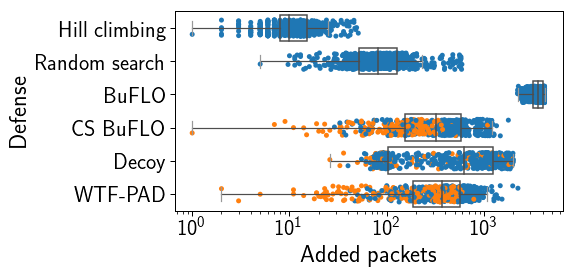

In [22]:
clean_overhead_data = overhead_data.dropna()
increase_data = pd.DataFrame()

for defense in defense_names:
    df = clean_overhead_data
    defense_success = success_data.query("defense == '%s'" % defense)
    assert np.all(df[defense].index == df[GS_DEF_NAME].index)
    increase_data = increase_data.append(
        pd.concat({
            "increase": (df[defense]),
            "defense": pd.Series([defense] * len(df), index=df.index),
            "success": pd.Series(
                [defense_success.query("filename == '%s'" % f).success.max() for f in df.index],
                index=df.index)
        }, axis=1), ignore_index=True
    )
increase_data = increase_data[increase_data["increase"] != np.inf]

fig, ax = plt.subplots()
sns.boxplot(data=increase_data, x="increase", y="defense", showfliers=False,
            palette={d: "white" for d in defense_names},
            boxprops=dict(linewidth=1.5, color=(0.3, 0.3, 0.3)),
            medianprops=dict(linewidth=1.5, color=(0.3, 0.3, 0.3)),
            whiskerprops=dict(color=(0.3, 0.3, 0.3)),
            zorder=1,
            ax=ax)

# Make boxes transparent
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

sns.stripplot(data=increase_data, x="increase", y="defense",
              hue="success", hue_order=[True, False],
              jitter=0.25,
              zorder=0,
              ax=ax)

ax.vlines(0, 0, 5, linestyles="--", color="lightgray")

ax.set_xscale("log")
ax.set_xlabel("Added packets")
ax.set_ylabel("Defense")

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT / 1.5)
fig.set_tight_layout(tight=True)

ax.get_legend().remove()
# legend.get_texts()[0].set_text("S")
# legend.get_texts()[1].set_text("F")

if SAVE_PLOTS:
    save_fig(fig, 'wfp__defs_packets_comparison.pdf')

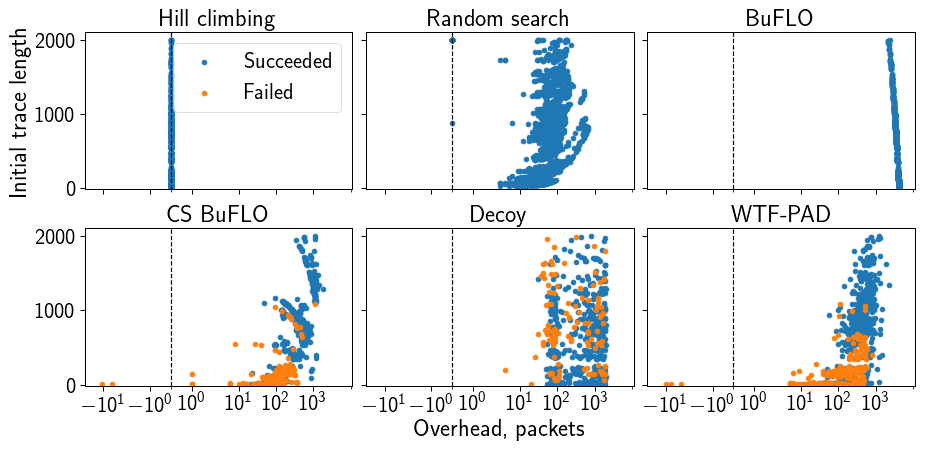

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True)
axes_flatten = []
for ax_row in axes:
    axes_flatten.extend(ax_row)

baseline_df = all_defenses_summary.query("defense == '%s'" % GS_DEF_NAME).set_index("filename")
for defense, ax in zip(defense_names, axes_flatten):
    df = all_defenses_summary.query("defense == '%s'" % defense)
    
    # Prepare the dataset for lm fit
    baseline_packets = baseline_df.ix[df.filename]["packets_added"]
    baseline_packets.index = df.index
    df = df.rename(columns={"packets_added": "packets"})
    df.tracelen = df.tracelen.astype("float")
    df.packets = df.packets.astype("float") - baseline_packets
    df["success"] = df.eval("svmpred >= 0.501") 
    
    ax.scatter(y=df.query("success").tracelen, x=df.query("success").packets,
                color=sns.color_palette()[0], label="Succeeded")
    ax.scatter(y=df.query("not success").tracelen, x=df.query("not success").packets,
                color=sns.color_palette()[1], label="Failed")
    ax.set_title(defense)
    
    ax.vlines(0, -10, 2200, linestyles="--")
    
    ax.set_ylim(-10, 2100)
#     ax.set_yscale("log")
    ax.set_xscale("symlog")
    ax.set_xticks([-10**1, -1, 1, 10**1, 10**2, 10**3])

axes_flatten[0].legend()
axes[1][1].set_xlabel("Overhead, packets")
axes[0][0].set_ylabel("Initial trace length")

fig.set_figwidth(FIGWIDTH * 1.75)
fig.set_figheight(FIGHEIGHT)

plt.subplots_adjust(wspace=0.05, hspace=.25)
plt.show()

if SAVE_PLOTS:
    save_fig(fig, 'wfp__defs_overhead_comparison.pdf')

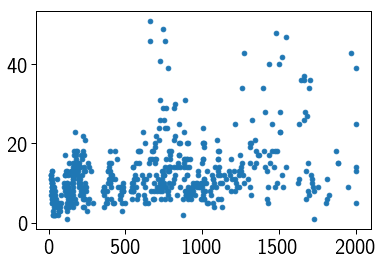

In [24]:
df = all_defenses_summary.query("defense == '%s'" % GS_DEF_NAME)
df = df.rename(columns={"packets_added": "packets"})
df["success"] = df["svmpred"] > 0.501

fig, ax = plt.subplots()
ax.scatter(x=df.tracelen, y=df.packets,
            color=sns.color_palette()[0], label="Succeeded")

plt.show()

In [25]:
df.packets.min(), df.packets.mean(), df.packets.max()

(1.0, 12.223570190641247, 51.0)

In [26]:
overhead_delta_data = pd.DataFrame()
for defense in baseline_defenses:
    df = overhead_data
    bad_baseline = df[defense] < df[GS_DEF_NAME]
    success_mask = (def_summary["svmpred"] > 0.5) & (def_summary["defense"] == defense)
    success_filenames = def_summary[success_mask]["filename"]
    overhead_delta_data = overhead_delta_data.append(
        pd.concat({
            "bad_baseline": bad_baseline,
            "success": pd.Series(df.index.isin(success_filenames), index=df.index),
            "defense": pd.Series([defense] * len(df), index=df.index)
        }, axis=1), ignore_index=True
    )

overhead_delta_data.pivot_table(columns="defense")

defense,BuFLO,CS BuFLO,Decoy,WTF-PAD
bad_baseline,0.000000,0.003466,0.000000,0.005199
success,0.993068,0.741768,0.802426,0.686308


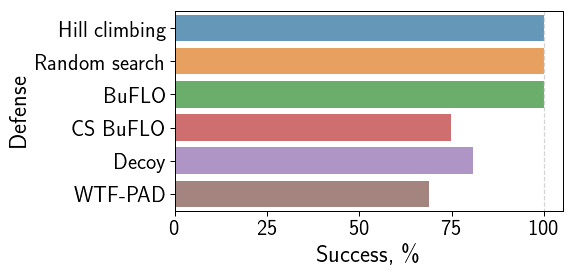

In [27]:
fig, ax = plt.subplots()

baseline_mean = success_data.query("defense == '%s'" % GS_DEF_NAME).success.mean()
ax.vlines(baseline_mean * 100, -.5, 5.5, linestyles="--", color="lightgray")

gs_success = success_data.query("defense == '%s'" % GS_DEF_NAME)
gs_success.success = gs_success.success.astype("float")

random_success = success_data.query("defense == 'Random search'")
random_success.success = random_success.success.astype("float")

defenses_success = success_data.query("defense not in ['%s','Random search']" % GS_DEF_NAME)
defenses_success = defenses_success.groupby("defense").mean()
defenses_success["defense"] = defenses_success.index

sns.barplot(
    data=pd.concat([gs_success, random_success, defenses_success]),
    x="success", y="defense",
    estimator=lambda vals: vals.max() * 100,
    alpha=0.75,
    ax=ax)

ax.set_xlabel("Success, \%")
ax.set_ylabel("Defense")

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT / 1.5)
fig.set_tight_layout(tight=True)

if SAVE_PLOTS:
    save_fig(fig, 'wfp__defs_success_comparison.pdf')